In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

sys.path.append('../src')
from ocr.normalization import word_normalization, letter_normalization
from ocr.helpers import implt, resize
from ocr.tfhelpers import Model
from ocr.datahelpers import idx2char
from ocr import page, words, characters

Instructions for updating:
non-resource variables are not supported in the long term
Loading segmentation models...
INFO:tensorflow:Restoring parameters from C:\Users\Sampat\Documents\DPIML\src\ocr\../../models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from C:\Users\Sampat\Documents\DPIML\src\ocr\../../models/gap-clas/RNN/Bi-RNN-new


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0)

### Global Variables

In [4]:
IMG = '../data/pages/p2.jpg'    # 1, 2, 3
LANG = 'en'
# You can use only one of these two
# You HABE TO train the CTC model by yourself using word_classifier_CTC.ipynb
MODEL_LOC_CHARS = '../models/char-clas/' + LANG + '/CharClassifier'
MODEL_LOC_CTC = '../models/word-clas/CTC/Classifier1'
f = open("../p2.txt", "r")
ctc=f.read()

## Load Trained Model

In [5]:
CHARACTER_MODEL = Model(MODEL_LOC_CHARS)
CTC_MODEL = Model(MODEL_LOC_CTC, 'word_prediction')

INFO:tensorflow:Restoring parameters from ../models/char-clas/en/CharClassifier
INFO:tensorflow:Restoring parameters from ../models/word-clas/CTC/Classifier1


## Load image

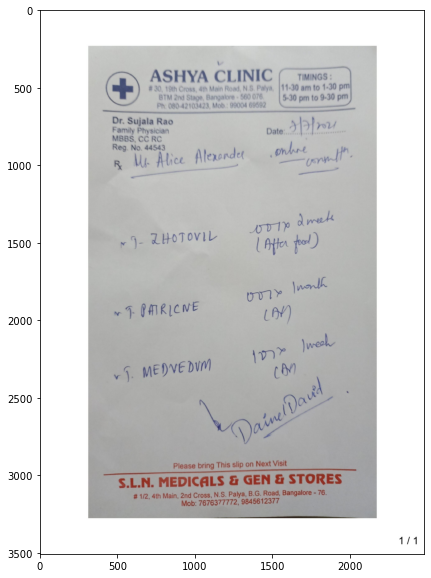

In [6]:
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
implt(image)

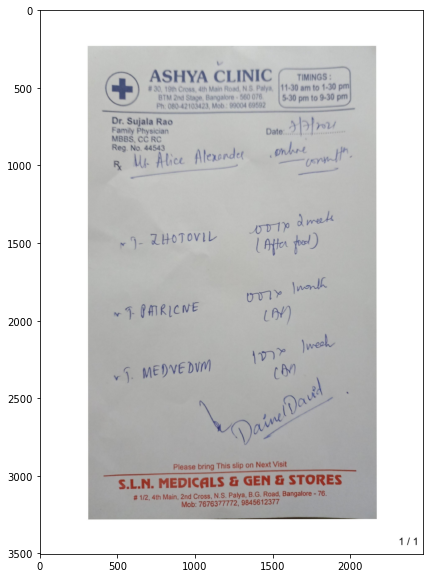

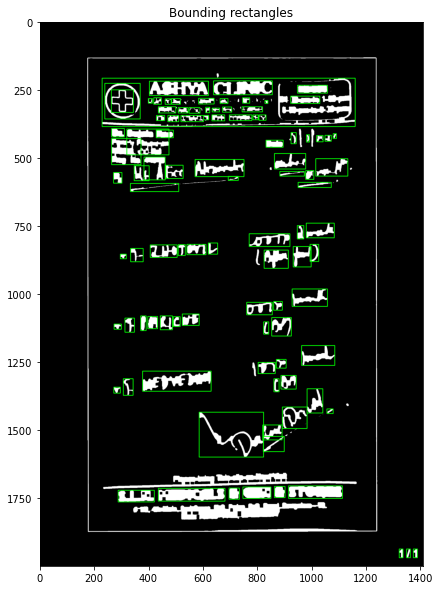

[[ 399  360 2029  672]
 [1117  378 1495  467]
 [ 704  380 1084  472]
 [ 416  394  644  623]
 [1658  406 1851  457]
 [ 458  436  600  581]
 [1614  476 1802  523]
 [ 732  486  781  528]
 [1304  486 1350  521]
 [1021  490 1120  527]
 [ 697  492  723  521]
 [ 847  492  903  528]
 [1159  492 1210  523]
 [ 805  493  844  528]
 [1448  504 1467  523]
 [ 761  544  873  585]
 [1301  544 1432  577]
 [1175  546 1234  579]
 [1066  548 1092  583]
 [ 889  549  952  585]
 [ 959  549 1029  586]
 [1108  553 1155  577]
 [1106  597 1189  635]
 [1219  597 1364  634]
 [1371  597 1404  628]
 [1409  597 1455  632]
 [ 749  600  802  634]
 [ 823  600  893  641]
 [ 907  600 1052  641]
 [1052  600 1085  628]
 [ 460  684  542  739]
 [ 558  688  830  854]
 [ 747  695  858  744]
 [1616  711 1649  782]
 [1888  718 1909  749]
 [1716  725 1735  772]
 [1835  728 1875  767]
 [1781  730 1823  770]
 [ 460  749  649  917]
 [1455  760 1565  805]
 [1509  845 1711  945]
 [ 669  868  805 1015]
 [1776  879 1982  991]
 [ 998  884

In [7]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
boxes = words.detection(crop)
lines = words.sort_words(boxes)
print(boxes)
print(lines)

# Recognition Using Character + Separator Model + Correction

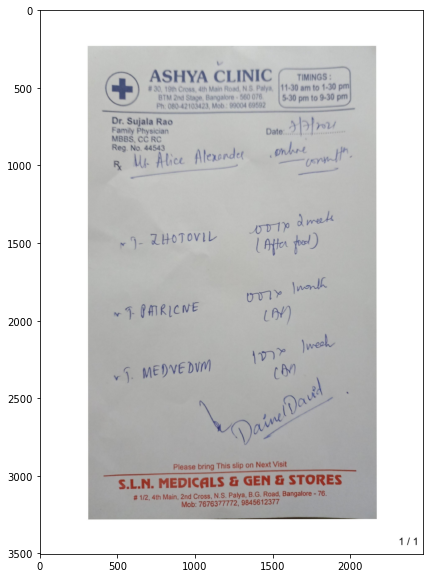

olSzeezeaaelaaaee oej roeegr woco phhjpoo
v ee oA lel oef eeeu n v q vno
n epgke raD ve eelaoee eeee go H heholr ehgu ear exgbeu fleeef ee ee
aa aeu aaaa ceo g g gg je j
on
m deecpelel mkae nalg
a hk kce i n a
n n
vTiv d nde
n Ii em p alph c gm lod I
mvgnlk
OTil G
a p q m al c the C eelI
meeh
Vr v
q kePrjeDhlhI C lm
o d
Xw ja v
url p
ooeoovo oeeegheooeeo eee oev eee ecooeo
p t p
+     ASHYA CLINIC TIMiMGS


ph     0 0-421  34 23    

Dr.Shuiala R o

MBBS OO RC
Reg  No 44543

dafe  |   |

W. Alic                      onhe




l ZHO toViL   001  Affer fool


T PATR | C ne



T MEDVEDM         1  01      1 weeh





Da??! Dav

S L N Medicals ? GEN ? STORES

78783777772  9545612377 


In [8]:
def recognise(img):
    """Recognition using character model"""
    # Pre-processing the word
    img = word_normalization(
        img,
        60,
        border=False,
        tilt=True,
        hyst_norm=True)

    # Separate letters
    img = cv2.copyMakeBorder(
        img,
        0, 0, 30, 30,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0])
    gaps = characters.segment(img, RNN=True)

    chars = []
    for i in range(len(gaps)-1):
        char = img[:, gaps[i]:gaps[i+1]]
        char, dim = letter_normalization(char, is_thresh=True, dim=True)
        # TODO Test different values
        if dim[0] > 4 and dim[1] > 4:
            chars.append(char.flatten())

    chars = np.array(chars)
    word = ''        
    if len(chars) != 0:
        pred = CHARACTER_MODEL.run(chars)                
        for c in pred:
            word += idx2char(c)

    return word

implt(crop)

for line in lines:
    print(" ".join([recognise(crop[y1:y2, x1:x2]) for (x1, y1, x2, y2) in line]))
    
print(ctc)